# Procesamiento Digital de Audio
## Caleb Rascón
### Separación de Fuentes en Línea

#### MVDR - Minimun Variance Distortionless Response

In [2]:
#Bibliotecas
import numpy as np
from matplotlib import pyplot as plt
from delay_f import delay_f

In [3]:
# Parameters
doa1 = 20 * np.pi / 180  # Direction of arrival of first signal
doa2 = -40 * np.pi / 180  # Direction of arrival of second signal
doa_steer = doa1  # Direction to steer the beamformer
d = 4  # Distance between microphones in meters
M = 8  # Number of microphones
amp_out = 1  # Post-amplification for beamformer output
N = 200  # Signal size in samples

In [4]:
# Simulating signals
t = np.arange(1, N + 1) / N  # Time vector (1 second)
c = 343  # Speed of sound
fs = N  # Sampling frequency same as signal size (1 second)

# Original signals
s1 = np.cos(2 * np.pi * 2 * t)
s2 = np.abs(np.mod(np.arange(N) * 10 / N, 2) - 1) * 2 - 1  # Triangle wave with amplitude 0.5
s2 = s2 * 0.5

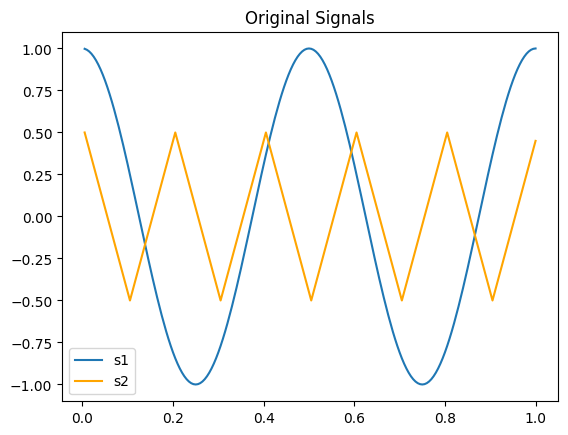

In [5]:
plt.plot(t, s1, label="s1")
plt.plot(t, s2, label="s2", color='orange')
plt.legend()
plt.title('Original Signals')
plt.show()

In [6]:
# Microphones (input signals)
X = np.zeros((M, N))

X[0, :] = s1 + s2
for m in range(1, M):
    X[m, :] = delay_f(s1, (m * d / c) * np.sin(doa1), fs) + delay_f(s2, (m * d / c) * np.sin(doa2), fs)


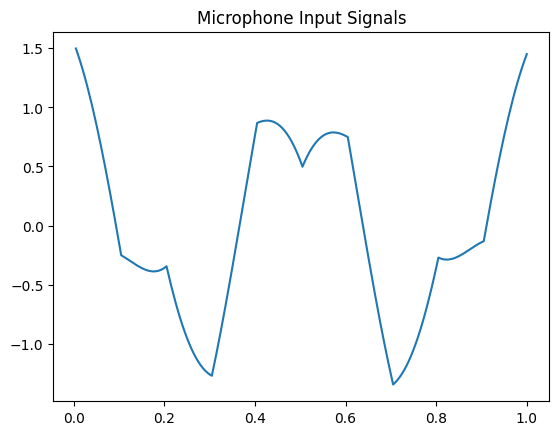

In [7]:
plt.plot(t, X[0, :])
plt.title('Microphone Input Signals')
plt.show()


In [8]:

# Calculating the base steering vector
w_c = np.zeros((M, N), dtype=complex)
w = np.concatenate(([0], np.arange(1, N//2+1), np.arange(-N//2+1, 0))) / N * fs
w_c[0, :] = np.ones(N)

for m in range(1, M):
    for f in range(N):
        w_c[m, f] = np.exp(-1j * (2 * np.pi * w[f] * m * d / c) * np.sin(doa_steer))

# FFT
X = np.fft.fft(X, axis=1)

# Applying beamformer
o_f = np.zeros(N, dtype=complex)
for f in range(1, N):
    R = np.outer(X[:, f], X[:, f].conj())  # Covariance matrix

    # Fixing steering mismatch in the covariance matrix so that it is invertible
    R += np.eye(M) * 0.001 * np.diag(R)
    inv_R = np.linalg.pinv(R)  # Pseudo-inverse for robustness

    w_a = w_c[:, f]

    # Calculating the optimal beamformer weights
    w_o = np.dot(inv_R, w_a) / np.dot(np.dot(w_a.conj().T, inv_R), w_a)
    o_f[f] = np.dot(w_o.conj().T, X[:, f])

o = np.real(np.fft.ifft(o_f))
o = o * amp_out


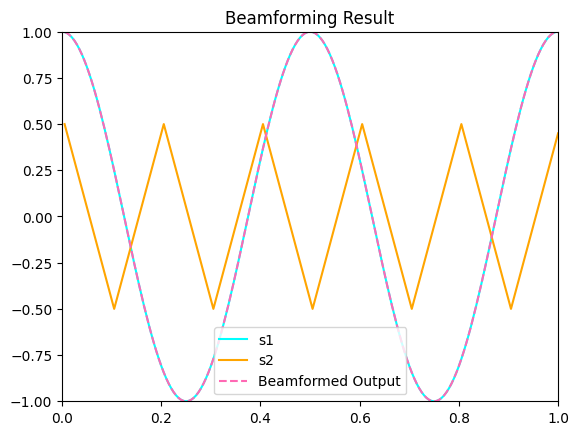

In [9]:
plt.plot(t, s1, label='s1', color='aqua')
plt.plot(t, s2, label='s2', color='orange')
plt.plot(t, o, '--', color='hotpink', label='Beamformed Output')
plt.axis([0, 1, -1, 1])
plt.legend()
plt.title('Beamforming Result')
plt.show()